# Train Detectors

In this notebook we will train an detector using MMDetection.

## Prepare the Dataset

We have already prepared a dataset, a tiny subset from the KITTI autonomous driving datset.

Our task is to detect pedestrian, cars, etc from street view images.

To download and extract the dataset, in command line:

```
curl https://download.openmmlab.com/mmdetection/data/kitti_tiny.zip -o kitti_tiny.zip
unzip -d data kitti_tiny.zip
```

The dataset contain *image files*, *label files* and *train/test splits*.

## Format the Dataset

Definition of Kitti annotation can be found [here](https://github.com/bostondiditeam/kitti/blob/master/resources/devkit_object/readme.txt#L46).

To train with MMDetection, we need to generate an annotation file with the following format.

```python
[
    {
        'filename': 'a.jpg',
        'width': 1280,
        'height': 720,
        'ann': {
            'bboxes': <np.ndarray, float32> (n, 4),
            'labels': <np.ndarray, int64> (n, ),
            'bboxes_ignore': <np.ndarray, float32> (k, 4),
            'labels_ignore': <np.ndarray, int64> (k, ) (optional field)
        }
    },
    ...
]
```

In [1]:
import mmcv
import numpy as np

CLASSES = []
data_infos = []

for idx in range(75):
    imfile = f"data/kitti_tiny/training/image_2/{idx:06d}.jpeg"
    annfile = f"data/kitti_tiny/training/label_2/{idx:06d}.txt"

    image = mmcv.imread(imfile)
    height, width = image.shape[:2]

    ann = mmcv.list_from_file(annfile)

    gt_bboxes = []
    gt_labels = []
    gt_bboxes_ignore = []

    for line in ann:
        line = line.split(' ')
        bbox = [float(line[i]) for i in range(4,8)]
        
        if line[0] == 'DontCare':
            gt_bboxes_ignore.append(bbox)
        else:
            gt_bboxes.append(bbox)
            if line[0] not in CLASSES:
                CLASSES.append(line[0])
            gt_labels.append(CLASSES.index(line[0]))

    data_infos.append(
        dict(
            filename=f"{idx:06d}.jpeg",
            width=width,
            height=height,
            ann = dict(
                bboxes=np.array(gt_bboxes, dtype=np.float32).reshape(-1,4),
                labels=np.array(gt_labels, dtype=np.int64).reshape(-1),
                bboxes_ignore=np.array(gt_bboxes_ignore, dtype=np.float32).reshape(-1,4),
            )
    ))
    
print(CLASSES)
mmcv.dump(data_infos[:50], 'data/kitti_tiny/train_ann.pkl')
mmcv.dump(data_infos[50:], 'data/kitti_tiny/test_ann.pkl')

['Pedestrian', 'Truck', 'Car', 'Cyclist', 'Misc', 'Van', 'Tram', 'Person_sitting']


## Prepare a Config and Checkpoint File

We choose to use RetinaNet. 

Use mim to download the config file and checkpoint file.

```
mim download mmcls --config retinanet_r18_fpn_1x_coco --dest .
mv retinanet_r18_fpn_1x_coco.py retinanet_r18_fpn_1x_kitti.py
```

If you prefer to play with other models, navigate to [MMDetection model zoo](https://github.com/open-mmlab/mmdetection#overview-of-benchmark-and-model-zoo).

In [2]:
!mim download mmdet --config retinanet_r18_fpn_1x_coco --dest . 

processing retinanet_r18_fpn_1x_coco...
retinanet_r18_fpn_1x_coco_20220407_171055-614fd399.pth exists in C:\Users\wangruohui\Desktop\sjtu-openmmlab-tutorial
Successfully dumped retinanet_r18_fpn_1x_coco.py to C:\Users\wangruohui\Desktop\sjtu-openmmlab-tutorial


C:\Users\wangruohui\Miniconda3\envs\mm\lib\site-packages\_distutils_hack\__init__.py:30: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


## Modify the Config File

1. Remove some intermediate item for clean: `dataset_type`, `img_norm_cfg`, `train_pipeline`, `test_pipeline`
1. Modify model
    1. number of class in `bbox_head`: from 80 to 8
    2. `inif_cfg`: to None
    3. `load_from`: to the checkpoint we downloaded
1. Data: for train/val/test 
    1. `type`: `CocoDataset` -> `CustomDataset`
    2. `prefix`, which is the root path to images: modify to `"data/kitti_tiny/training/image_2/"`
    3. `ann_file`, the pickle file we just generates: modify to `data/kitti_tiny/train_ann.pkl` for training subset and `data/kitti_tiny/val_ann.pkl` for validation / test subset
    4. `evaluation.metric`: to `'mAP'`, which is designed for `CustomDataset`
1. Runner and Optimizer
    1. `optimizer.lr`: decrease learning rates based on linear scaling rule and for fine-tuning. 
    1. `lr_config`, decrease `warmup_iters` as we don't have that much iters for small dataset.
1. Misc
    1. Decrease `log_confg.interval` for more logs
    1. Increase `checkpoint_config.interval` to avoid saving too many checkpoints, to save time and disk space

## Launch Training

In command line

```
mim train mmdet retinanet_r18_fpn_1x_kitti.py
```

## Understand Logs


The log is long but mainly contains the following parts:

1. Toolbox information
2. Dumped Config files
3. Model Initialization Logs
    1. Check `mmdet - INFO - load checkpoint from local path: retinanet_r18_fpn_1x_coco_20220407_171055-614fd399.pth`, which means pretrained weights are loaded correctly.
4. Information on Hooks: we don't configure this explicitly in this tutorial, so ignore that
5. Training progress
    1. Training logs: including current learning, training loss, time consumption, memory occupation
    2. Validation logs: meanAP on validation set
```


## Test the Model

The trained model (checkpoint file) is usually saved under `work_dirs/{experiment_name}/latest.pth`. 
We can load it to test with a new image. 

load checkpoint from local path: work_dirs/retinanet_r18_fpn_1x_kitti/latest.pth


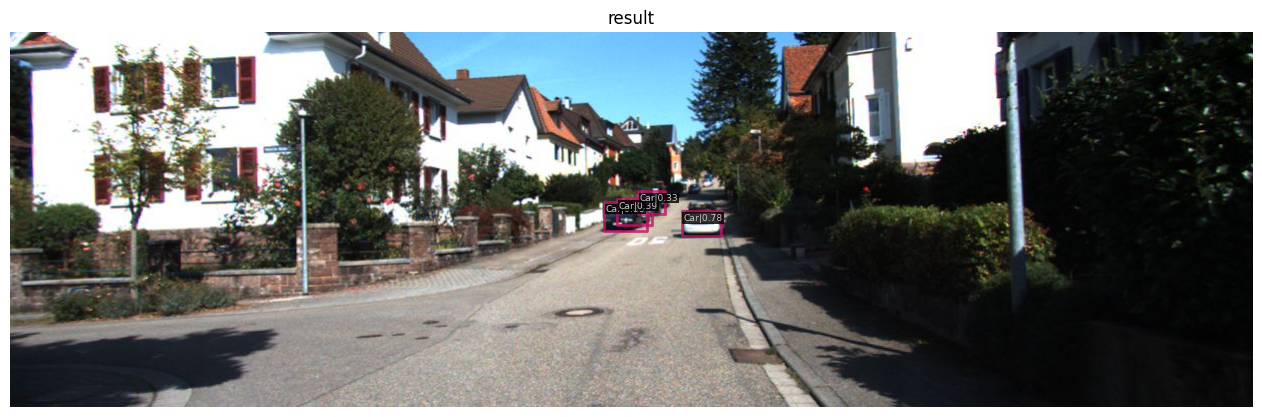

In [9]:
from mmdet.apis import init_detector, inference_detector, show_result_pyplot

image = 'data/kitti_tiny/training/image_2/000066.jpeg'
model = init_detector('retinanet_r18_fpn_1x_kitti.py', 'work_dirs/retinanet_r18_fpn_1x_kitti/latest.pth')
result = inference_detector(model, image)
show_result_pyplot(model, image, result)

In [10]:
# !mim test mmdet retinanet_r18_fpn_1x_kitti.py --checkpoint work_dirs/retinanet_r18_fpn_1x_kitti/latest.pth --eval mAP
!mim test mmdet retinanet_r18_fpn_1x_kitti.py --checkpoint work_dirs/retinanet_r18_fpn_1x_kitti/latest.pth --show-dir work_dirs

Testing command is python c:\users\wangruohui\miniconda3\envs\mm\lib\site-packages\mmdet\.mim\tools\test.py retinanet_r18_fpn_1x_kitti.py work_dirs/retinanet_r18_fpn_1x_kitti/latest.pth --launcher none --show-dir work_dirs. 
load checkpoint from local path: work_dirs/retinanet_r18_fpn_1x_kitti/latest.pth
[                                                  ] 0/25, elapsed: 0s, ETA:
[>                                 ] 1/25, 0.1 task/s, elapsed: 7s, ETA:   164s
[>>                                ] 2/25, 0.3 task/s, elapsed: 7s, ETA:    82s
[>>>>                              ] 3/25, 0.4 task/s, elapsed: 7s, ETA:    54s
[>>>>>                             ] 4/25, 0.5 task/s, elapsed: 8s, ETA:    40s
[>>>>>>                            ] 5/25, 0.6 task/s, elapsed: 8s, ETA:    31s
[>>>>>>>>                          ] 6/25, 0.8 task/s, elapsed: 8s, ETA:    25s
[>>>>>>>>>                         ] 7/25, 0.9 task/s, elapsed: 8s, ETA:    21s
[>>>>>>>>>>                        ] 8/25, 1.0 task/s, el

C:\Users\wangruohui\Miniconda3\envs\mm\lib\site-packages\mmdet\utils\setup_env.py:38: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  warnings.warn(
C:\Users\wangruohui\Miniconda3\envs\mm\lib\site-packages\mmdet\utils\setup_env.py:48: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  warnings.warn(
C:\Users\wangruohui\Miniconda3\envs\mm\lib\site-packages\_distutils_hack\__init__.py:30: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
